In [22]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


In [23]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
N = 16
minibatch_size = 4096

def reconstruction_error(Out, Original):
    return torch.mean( torch.sum( torch.sign(Original) != torch.sign(Out), dim=1)
                       .to(torch.float), dim=0).item()

def gen_bitstring(N, batch_size=minibatch_size):
    return torch.randint(low=0, high=2, size=(batch_size,N), dtype=torch.float).to(DEVICE)*2-1


In [24]:
class ABENet(nn.Module):
    def __init__(self, N, has_key=True):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=2*N if has_key else N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x


class EPPNet(nn.Module):
    def __init__(self, N):
        super(EPPNet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv5 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv6 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.sigmoid( self.conv4(x) )
        x = torch.sigmoid( self.conv5(x) )
        x = torch.tanh(    self.conv6(x) )
        x = x.view(-1, self.N)
        return x


In [25]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda', index=0)

In [38]:

EPP_NO, EPP_LAYER, EPP_RAND = range(3)

l1_norm = nn.L1Loss()
loss_eve = l1_norm
loss_bob = l1_norm
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))


def train_abe(A, B, E,
              lr=0.0008,
              max_iter=150000,
              debug_print=1000,
              loss_eve=loss_eve,
              loss_alicebob=loss_alicebob,
              stop_condition=(lambda AB_loss, E_loss, AB_rec, E_rec:
                              #AB_loss < 0.005 and E_loss > 0.5
                              AB_rec < 0.05 and E_rec > 7.5),
              EPP=EPP_NO):
    
    # Optimizers
    A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
    B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
    E_optimizer = optim.Adam(E.parameters(), lr=0.0008)

    ABs = [] # AB loss values
    Es  = [] # E loss values

    Rec_B = []
    Rec_E = []
    
    [X.train() for X in [A,B,E]] # Set models in training mode

    start_time = time.time()
    for ic in range(max_iter):
        # Train A/B for 1 minibtach and E for 2 minibatches to give it some advantage
        for who, num_minibatches in [('AB', 1), ('E', 2)]:
            for _ in range(num_minibatches):
                P = gen_bitstring(N, batch_size=minibatch_size)
                K = gen_bitstring(N, batch_size=minibatch_size) 

                C     = A(torch.cat((P, K), dim=1))
                P_bob = B(torch.cat((C, K), dim=1))
                if EPP == EPP_RAND:
                    RK = gen_bitstring(N, batch_size=minibatch_size)
                    P_eve = E(torch.cat((C, RK), dim=1))
                else:
                    P_eve = E(C)
                    
                if who == 'AB':
                    A_optimizer.zero_grad()
                    B_optimizer.zero_grad()
                    AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                    AB_loss.backward()
                    A_optimizer.step()
                    B_optimizer.step()
                
                elif who == 'E':
                    E_optimizer.zero_grad()
                    E_loss  = loss_eve(P_eve, P)
                    
                    E_loss.backward()
                    E_optimizer.step()

        if debug_print > 0 and ic % debug_print == (debug_print-1):
            elapsed_time = time.time() - start_time
            print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
                ic+1, AB_loss, E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

        AB_rec = reconstruction_error(P, P_bob)
        E_rec = reconstruction_error(P, P_eve)
        Rec_B.append(AB_rec)
        Rec_E.append(E_rec)
        ABs.append(AB_loss.item())
        Es.append(E_loss.item())

        if stop_condition(AB_loss, E_loss, AB_rec, E_rec):
            break

    [X.train(False) for X in [A,B,E]]
    return ABs, Es, Rec_B, Rec_E


def train_best_eve(A, E,
                   max_iter=250000,
                   retries=5,
                   debug_print=10000,
                   EPP=EPP_NO):

    Best_E_Rec = float("Inf")
    Best_E_loss = float("Inf")
    Best_E = None

    for es in range(retries):
        if EPP == EPP_LAYER:
            CE = EPPNet(N).to(DEVICE)
        elif EPP == EPP_RAND:
            CE = ABENet(N, has_key=True).to(DEVICE)
        else:
            CE = ABENet(N, has_key=False).to(DEVICE)
            
        CE_optimizer = optim.Adam(CE.parameters(), lr=0.0008)
        CE.train()
        start_time = time.time()
        for ic in range(max_iter):
            P = gen_bitstring(N, batch_size=minibatch_size)
            K = gen_bitstring(N, batch_size=minibatch_size)
                   
            C       = A(torch.cat((P, K), dim=1))
            if EPP == EPP_RAND:
                RK = gen_bitstring(N, batch_size=minibatch_size)
                P_eve = CE(torch.cat((C, RK), dim=1))
            else:
                P_eve = CE(C)

            CE_loss = loss_eve(P_eve, P)
            CE_optimizer.zero_grad()
            CE_loss.backward()
            CE_optimizer.step()

            if debug_print > 0 and ic % debug_print == (debug_print-1):
                elapsed_time = time.time() - start_time
                print("[{:d} - {:6d}] CE_loss: {:2.4f} Elapsed Time: {}".format(
                    es+1, ic+1, CE_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

            if CE_loss <= 0.05:
                raise RuntimeError("Optimal E found!")
                break
            
        if CE_loss.item() < Best_E_loss:
            Best_E_loss = CE_loss.item()
            Best_E = CE
            Best_E_Rec = reconstruction_error(P, P_eve)

    return Best_E, Best_E_loss, Best_E_Rec

def validate_pp(num_times=3, max_iter_abe=15000, retries=5, max_iter_e=15000, EPP=(EPP_NO, EPP_NO)):

    EPP_train, EPP_validate = EPP

    AB     = []
    AB_rec = []
    BE     = []
    BE_rec = []
    start_time = time.time()
    for n in range(num_times):
        A = ABENet(N, has_key=True).to(DEVICE)
        B = ABENet(N, has_key=True).to(DEVICE)

        if EPP_train == EPP_LAYER:
            # E++Layers
            E = EPPNet(N).to(DEVICE)
        elif EPP_train == EPP_RAND:
            # E++Random    
            E = ABENet(N, has_key=True).to(DEVICE)
        else:
            # E
            E = ABENet(N, has_key=False).to(DEVICE)

        ABs, Es, RABs, REs = train_abe(A,B,E, max_iter=max_iter_abe, debug_print=5000, EPP=EPP_train)
            
        _, Best_E_loss, BRE = train_best_eve(
            A, E, retries=retries, max_iter=max_iter_e, debug_print=7500, EPP=EPP_validate)

        AB.append(ABs[-1])
        AB_rec.append(RABs[-1])
        BE.append(Best_E_loss)
        BE_rec.append(BRE)
        elapsed_time = time.time() - start_time
        print("[N: {}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
            n+1, ABs[-1], Best_E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

    return AB, BE, AB_rec, BE_rec



In [27]:
def plot_best_eves(AB, BE):
    plt.figure(figsize=(14,8))
    plt.scatter(AB,BE, marker='x')
    plt.xlabel("Alice-Bob Error", fontsize=14)
    plt.ylabel("Best Eve Error", fontsize=14)
    plt.grid(True, which='both')
    plt.show()

In [32]:
AB1, BE1, AB_rec1, BE_rec1 = validate_pp(num_times=2, retries=3, max_iter_e=22500, EPP=(EPP_NO, EPP_LAYER))

[  5000] AB_loss: 0.0096 E_loss: 0.9170 Elapsed Time: 00:02:50


[1 -   7500] CE_loss: 0.8424 Elapsed Time: 00:01:27


[1 -  15000] CE_loss: 0.8430 Elapsed Time: 00:02:54


[1 -  22500] CE_loss: 0.8449 Elapsed Time: 00:04:21


[2 -   7500] CE_loss: 0.8402 Elapsed Time: 00:01:27


[2 -  15000] CE_loss: 0.8407 Elapsed Time: 00:02:54


[2 -  22500] CE_loss: 0.8410 Elapsed Time: 00:04:22


[3 -   7500] CE_loss: 0.8424 Elapsed Time: 00:01:26


[3 -  15000] CE_loss: 0.8283 Elapsed Time: 00:02:53


[3 -  22500] CE_loss: 0.8340 Elapsed Time: 00:04:20
[N: 1] AB_loss: 0.0083 E_loss: 0.8340 Elapsed Time: 00:16:17


[  5000] AB_loss: 0.0242 E_loss: 0.8808 Elapsed Time: 00:02:50


[1 -   7500] CE_loss: 0.8318 Elapsed Time: 00:01:27


[1 -  15000] CE_loss: 0.8359 Elapsed Time: 00:02:54


[1 -  22500] CE_loss: 0.8261 Elapsed Time: 00:04:21


[2 -   7500] CE_loss: 0.8601 Elapsed Time: 00:01:27


[2 -  15000] CE_loss: 0.8506 Elapsed Time: 00:02:54


[2 -  22500] CE_loss: 0.8482 Elapsed Time: 00:04:22


[3 -   7500] CE_loss: 0.8311 Elapsed Time: 00:01:27


[3 -  15000] CE_loss: 0.8345 Elapsed Time: 00:02:55


[3 -  22500] CE_loss: 0.8416 Elapsed Time: 00:04:22
[N: 2] AB_loss: 0.0067 E_loss: 0.8261 Elapsed Time: 00:33:12


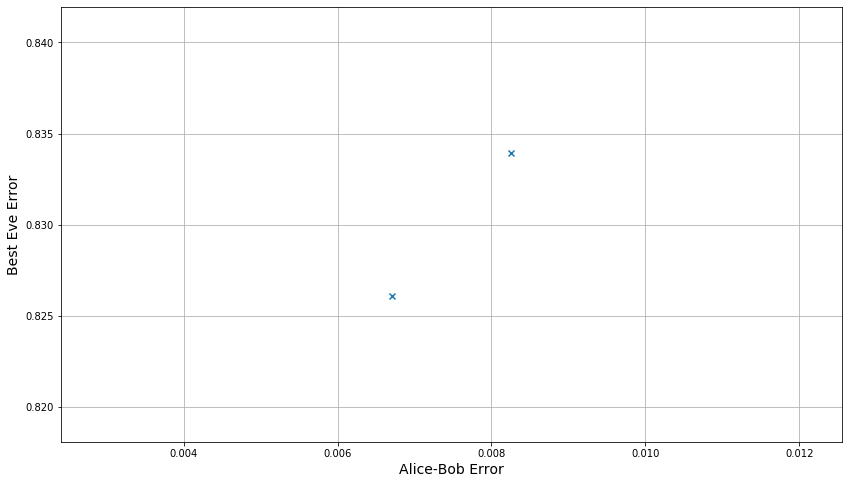

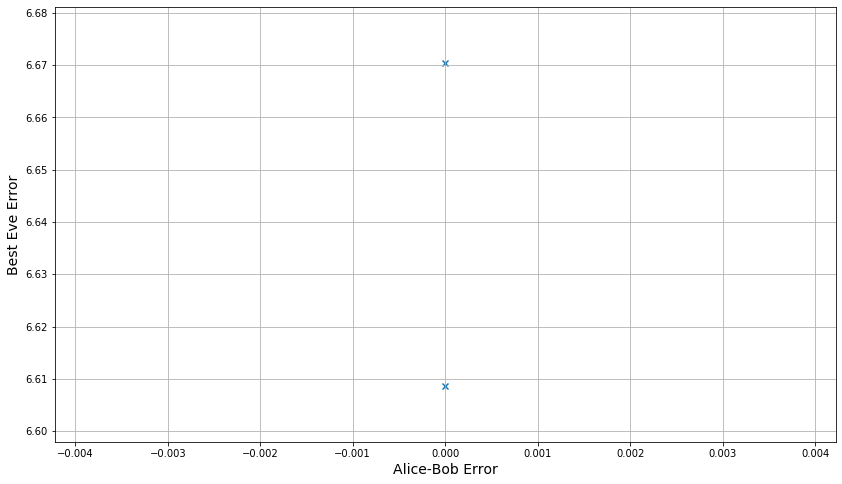

In [45]:
plot_best_eves(AB1, BE1)
plot_best_eves(AB_rec1, BE_rec1)

In [52]:
AB2, BE2, AB_rec2, BE_rec2 = validate_pp(num_times=2, retries=3, max_iter_e=22500, EPP=(EPP_LAYER, EPP_LAYER))

[  5000] AB_loss: 0.0575 E_loss: 0.8181 Elapsed Time: 00:03:17


[1 -   7500] CE_loss: 0.8271 Elapsed Time: 00:01:27


[1 -  15000] CE_loss: 0.8354 Elapsed Time: 00:02:54


[1 -  22500] CE_loss: 0.8300 Elapsed Time: 00:04:20


[2 -   7500] CE_loss: 0.8380 Elapsed Time: 00:01:27


[2 -  15000] CE_loss: 0.8338 Elapsed Time: 00:02:54


[2 -  22500] CE_loss: 0.8338 Elapsed Time: 00:04:22


[3 -   7500] CE_loss: 0.8253 Elapsed Time: 00:01:27


[3 -  15000] CE_loss: 0.8233 Elapsed Time: 00:02:54


[3 -  22500] CE_loss: 0.8184 Elapsed Time: 00:04:22
[N: 1] AB_loss: 0.0076 E_loss: 0.8184 Elapsed Time: 00:18:18


[  5000] AB_loss: 0.0105 E_loss: 0.9191 Elapsed Time: 00:03:17


[1 -   7500] CE_loss: 0.8498 Elapsed Time: 00:01:27


[1 -  15000] CE_loss: 0.8447 Elapsed Time: 00:02:55


[1 -  22500] CE_loss: 0.8478 Elapsed Time: 00:04:22


[2 -   7500] CE_loss: 0.8517 Elapsed Time: 00:01:26


[2 -  15000] CE_loss: 0.8505 Elapsed Time: 00:02:53


[2 -  22500] CE_loss: 0.8488 Elapsed Time: 00:04:20


[3 -   7500] CE_loss: 0.8499 Elapsed Time: 00:01:26


[3 -  15000] CE_loss: 0.8368 Elapsed Time: 00:02:53


[3 -  22500] CE_loss: 0.8402 Elapsed Time: 00:04:20
[N: 2] AB_loss: 0.0076 E_loss: 0.8402 Elapsed Time: 00:35:02


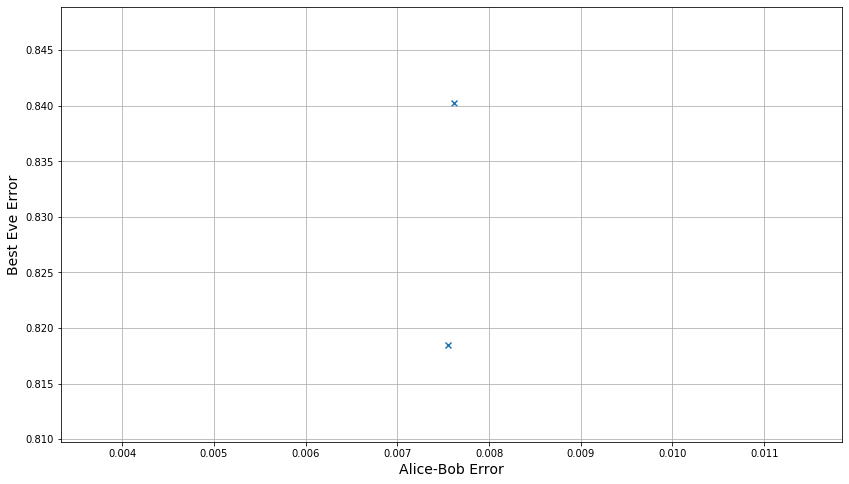

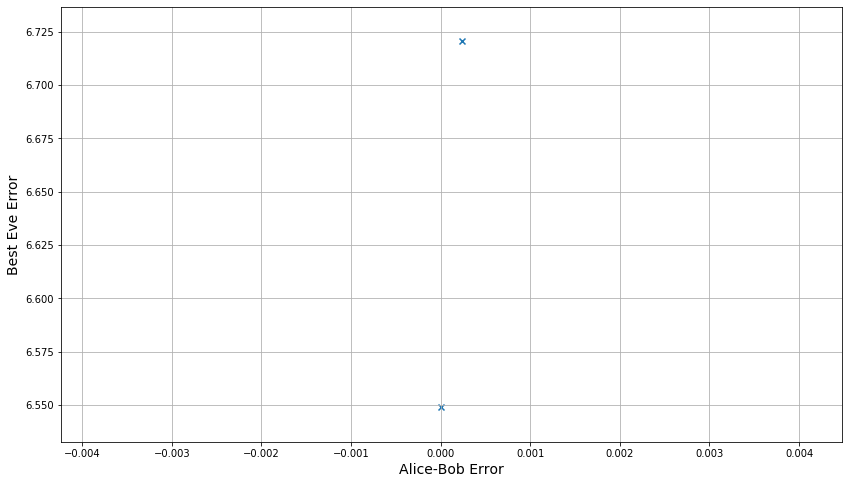

In [53]:
plot_best_eves(AB2, BE2)
plot_best_eves(AB_rec2, BE_rec2)

In [39]:
AB3, BE3, AB_rec3, BE_rec3 = validate_pp(num_times=2, retries=3, EPP=(EPP_RAND, EPP_RAND))

[  5000] AB_loss: 0.2751 E_loss: 0.6211 Elapsed Time: 00:03:00


[1 -   7500] CE_loss: 0.8225 Elapsed Time: 00:01:18


[1 -  15000] CE_loss: 0.8236 Elapsed Time: 00:02:37


[2 -   7500] CE_loss: 0.8581 Elapsed Time: 00:01:19


[2 -  15000] CE_loss: 0.8272 Elapsed Time: 00:02:38


[3 -   7500] CE_loss: 0.8507 Elapsed Time: 00:01:19


[3 -  15000] CE_loss: 0.8511 Elapsed Time: 00:02:38
[N: 1] AB_loss: 0.0081 E_loss: 0.8236 Elapsed Time: 00:13:06


[  5000] AB_loss: 0.0752 E_loss: 0.9082 Elapsed Time: 00:03:00


[ 10000] AB_loss: 0.0640 E_loss: 0.9652 Elapsed Time: 00:06:00


[ 15000] AB_loss: 0.0649 E_loss: 0.9816 Elapsed Time: 00:09:01


[1 -   7500] CE_loss: 0.9045 Elapsed Time: 00:01:21


[1 -  15000] CE_loss: 0.8842 Elapsed Time: 00:02:40


[2 -   7500] CE_loss: 0.8928 Elapsed Time: 00:01:18


[2 -  15000] CE_loss: 0.8806 Elapsed Time: 00:02:37


[3 -   7500] CE_loss: 0.8809 Elapsed Time: 00:01:19


[3 -  15000] CE_loss: 0.8564 Elapsed Time: 00:02:38
[N: 2] AB_loss: 0.0649 E_loss: 0.8564 Elapsed Time: 00:30:04


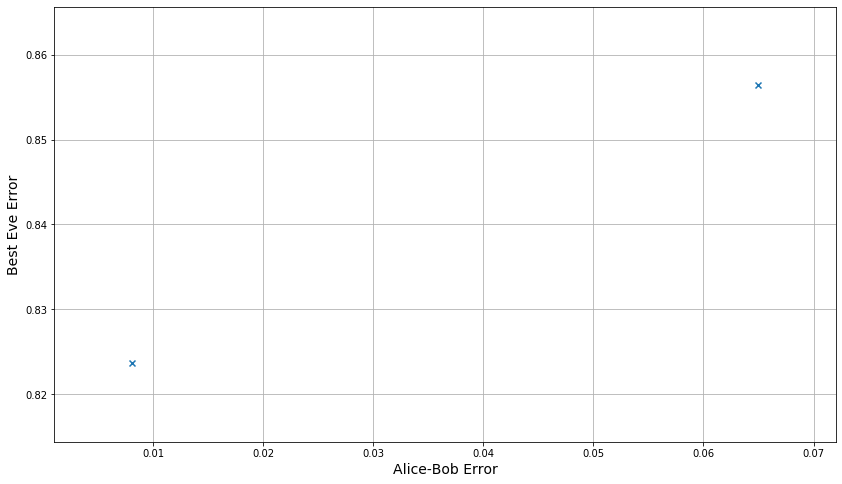

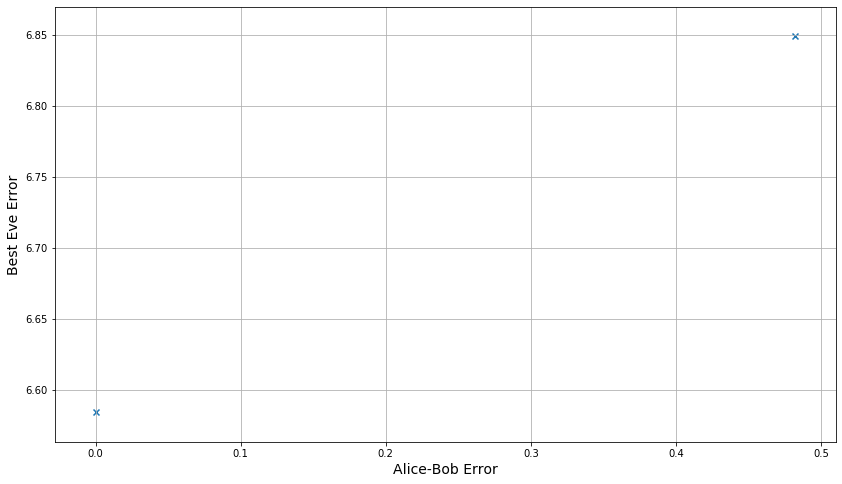

In [40]:
plot_best_eves(AB3, BE3)
plot_best_eves(AB_rec3, BE_rec3)

In [41]:
AB4, BE4, AB_rec4, BE_rec4 = validate_pp(num_times=2, retries=3, EPP=(EPP_RAND, EPP_RAND))

[  5000] AB_loss: 0.9994 E_loss: 0.9994 Elapsed Time: 00:03:00


[ 10000] AB_loss: 0.0454 E_loss: 0.8348 Elapsed Time: 00:06:00


[1 -   7500] CE_loss: 0.8253 Elapsed Time: 00:01:18


[1 -  15000] CE_loss: 0.8137 Elapsed Time: 00:02:37


[2 -   7500] CE_loss: 0.7999 Elapsed Time: 00:01:19


[2 -  15000] CE_loss: 0.7998 Elapsed Time: 00:02:38


[3 -   7500] CE_loss: 0.7889 Elapsed Time: 00:01:18


[3 -  15000] CE_loss: 0.7801 Elapsed Time: 00:02:37
[N: 1] AB_loss: 0.0066 E_loss: 0.7801 Elapsed Time: 00:15:48


[  5000] AB_loss: 0.1096 E_loss: 0.7505 Elapsed Time: 00:03:00


[1 -   7500] CE_loss: 0.8156 Elapsed Time: 00:01:19


[1 -  15000] CE_loss: 0.8073 Elapsed Time: 00:02:38


[2 -   7500] CE_loss: 0.8138 Elapsed Time: 00:01:18


[2 -  15000] CE_loss: 0.8040 Elapsed Time: 00:02:37


[3 -   7500] CE_loss: 0.8282 Elapsed Time: 00:01:19


[3 -  15000] CE_loss: 0.8216 Elapsed Time: 00:02:38
[N: 2] AB_loss: 0.0079 E_loss: 0.8040 Elapsed Time: 00:28:22


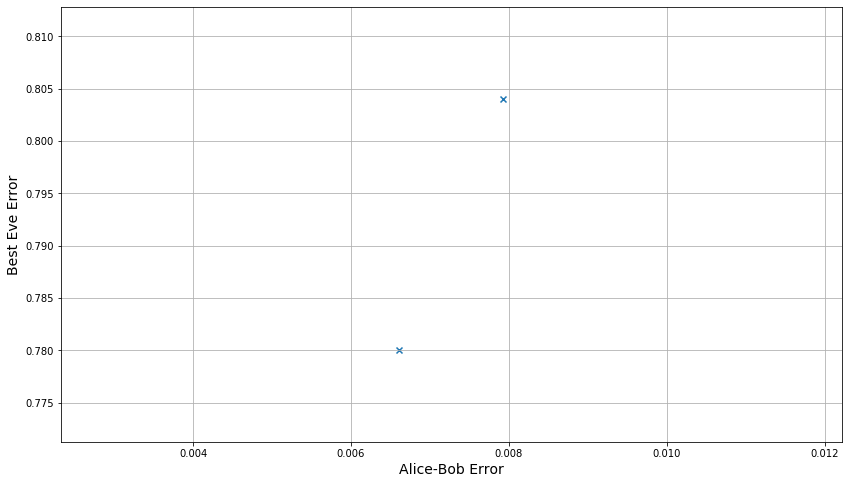

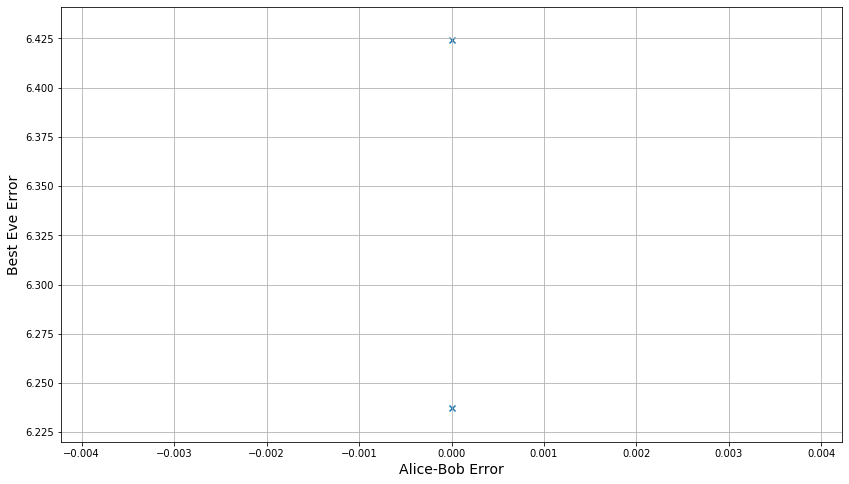

In [43]:
plot_best_eves(AB4, BE4)
plot_best_eves(AB_rec4, BE_rec4)